# Text Style Transfer Evaluation on WNC Full Corpus

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from src.evaluation import StyleTransferEvaluation

In [3]:
DATASETS_PATH = "/home/cdsw/data/processed/WNC_seq2seq_full"
SEQ2SEQ_MODEL_PATH = "/home/cdsw/models/bart-tst-full"
SBERT_MODEL_PATH = "sentence-transformers/all-MiniLM-L6-v2"
CLS_MODEL_PATH = (
    "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466"
)

ste = StyleTransferEvaluation(
    seq2seq_model_identifier=SEQ2SEQ_MODEL_PATH,
    cls_model_identifier=CLS_MODEL_PATH,
    sbert_model_identifier=SBERT_MODEL_PATH,
    dataset_identifier=DATASETS_PATH,
)

In [4]:
%%time
# ste.evaluate(save_name="metric_df_full")
ste.load_metric_df(name="metric_df_full")

Loaded `self.metric_df` from /home/cdsw/data/output/ste_metrics/metric_df_full.pkl
CPU times: user 27.5 ms, sys: 19.7 ms, total: 47.2 ms
Wall time: 98.8 ms


In [6]:
ste.metric_df[:10]

rev_id                                        source_text  \
0  407536752  djibouti, as well as the puntland and somalila...   
1  761493048  he is now a varsity basketball head coach for ...   
2  466100890  most notably, on september 11, 2011, the bushe...   
3  551290772  interestingly, wilfred rhodes, who had destroy...   
4  656809415  the positive contribution of post-keynesian ec...   
5   52114391  the new interface , which pc world describes a...   
6  708136164  he only walked out on three films during his p...   
7  304705607  the group publishes the american renaissance, ...   
8  139344342  reagan made occasional appearances on behalf o...   
9  469414492  chuck norris facts – awesome tall tales about ...   

                                         target_text  \
0  djibouti, as well as the puntland and somalila...   
1  he is now a varsity basketball head coach for ...   
2  the bushes joined the obamas in new york city ...   
3  wilfred rhodes, who had destroyed the derbyshi...   
4  the contribution of post-keynesian economics h...   
5  the new interface is intended to be cleaner an...   
6  he walked out on three films during his profes...   
7  the group publishes the american renaissance, ...   
8  reagan made occasional appearances on behalf o...   
9  chuck norris facts – tall tales about chuck no...   

                                           pred_text  pred_sti  target_sti  \
0  djibouti, as well as the puntland and somalila...    0.0016      0.0349   
1  he is now a varsity basketball head coach for ...    0.9437      0.9437   
2  in 2011, the bushes joined the obamas in new y...    0.1087      0.2052   
3  wilfred rhodes, who had destroyed the derbyshi...    0.0968      0.0968   
4  the effect of post-keynesian economics has ext...    0.1538      0.1748   
5  the new interface is intended to be cleaner an...   -0.1423     -0.1423   
6  he only walked out on three films during his p...    0.0000      0.5535   
7  the group publishes the american renaissance, ...    0.1535      0.1535   
8  reagan made occasional appearances on behalf o...    0.4407      0.0561   
9     chuck norris facts – tales about chuck norris.    0.9763      0.5969   

                                  masked_source_text  \
0  djibouti, as well as the puntland and somalila...   
1  he is now a varsity basketball head coach for ...   
2  most notably, on september 11, 2011, the bushe...   
3  [PAD]ly, wilfred rhodes, who had destroyed the...   
4  the positive [PAD] of post - keynesian economi...   
5  the new interface, which pc world describes as...   
6  he [PAD] walked out on three films during his ...   
7  the group publishes the american renaissance, ...   
8  reagan made occasional appearances on behalf o...   
9  chuck norris facts – [PAD] tall tales about ch...   

                                    masked_pred_text  pred_cps  \
0  djibouti, as well as the puntland and somalila...  0.997392   
1  he is now a [PAD] basketball head coach for th...  0.960442   
2  in 2011, the bushes joined the obamas in new y...  0.938260   
3  wilfred rhodes, who had destroyed the derbyshi...  0.963722   
4  the effect of post - keynesian economics has e...  0.959976   
5  the new interface is intended to be cleaner an...  0.631486   
6  he [PAD] walked out on three films during his ...  1.000000   
7  the group publishes the american renaissance, ...  0.966620   
8  reagan made occasional appearances on behalf o...  0.953143   
9     chuck norris [PAD] – tales about chuck norris.  0.882556   

                                  masked_target_text  target_cps  
0  djibouti, as well as the puntland and somalila...    0.977357  
1  he is now a [PAD] basketball head coach for th...    0.960442  
2  the bushes joined the obamas in new york city ...    0.928025  
3  wilfred rhodes, who had destroyed the derbyshi...    0.963722  
4  the contribution of post - keynesian economics...    0.966437  
5  the new interface is intended to be cleaner

## Inspect STI metric quality

Let's first see how our STI scores are distributed across the validation set.

Then, to help us understand how well our STI metric captures its intended goal, let's look at extreme examples where:

    a. `target_sti` < 0 
    b. `pred_sti` = 0
    c. `pred_sti` >> `target_sti`
    d. `pred_sti` << `target_sti`

### STI score distribution

In [33]:
ste.metric_df[["pred_sti", "target_sti"]].plot(
    kind="hist",
    bins=200,
    alpha=0.5,
    figsize=(18, 8),
    title="Distribution of STI Scores (predicted text vs. ground truth text)",
)

<AxesSubplot:title={'center':'Distribution of STI Scores (predicted text vs. ground truth text)'}, ylabel='Frequency'>

**Observations:**
1. We see that our predicted and target sti distributions are mostly consistent, which suggests the TST model is generally doing its job of neutralizing text to closely resemble that of the ground truth. However, there is a clear difference in the distributions at `STI = 0.00`. Here we see that there are a significant number of generations that result in 0 change in style -- meaning the model simply repeats the input as output. 
    - We should look into these, and also why we see any examples at all with target_sti == 0??
2. The general shape of the distribution leans net positive. This is expected. B
    - But why do we have any ground truth examples where the STI decreases?? Likely because our Style Classification model has errors.

### a. `target_sti` < 0

**Observations:**
- Sensibly, many of these appear to be data quality issues: 446940813, 184561602

In [35]:
def print_text_triplet(metric_df):

    for i, row in metric_df.iterrows():
        print(f"REV_ID: {row.rev_id}")
        print(f"SOURCE_TEXT: {row.source_text}")
        print(f"TARGET_TEXT: {row.target_text}")
        print(f"PREDIC_TEXT: {row.pred_text}")
        print("----------------------------------------------------")
        print()

In [39]:
print_text_triplet(
    ste.metric_df[ste.metric_df.target_sti < 0].sort_values(
        "target_sti", ascending=True
    )[:20]
)

REV_ID: 572068497
SOURCE_TEXT: marble arch is a white marble triumphal arch that now stands on a large traffic island at the junction of oxford street, park lane, and edgware road, almost directly opposite speakers' corner in hyde park in the city of westminster, london .
TARGET_TEXT: until 1851, it served as state entrance to the cour d'honneur of buckingham palace; it is now sited, isolated and incongruously, on a large traffic island at the junction of oxford street, park lane, and edgware road, almost directly opposite speakers' corner in hyde park in the city of westminster, london.
PREDIC_TEXT: marble arch is a white marble triumphal arch that now stands on a large traffic island at the junction of oxford street, park lane, and edgware road, almost directly opposite speakers' corner in hyde park in the city of westminster, london .
----------------------------------------------------

REV_ID: 789943864
SOURCE_TEXT: beaconsfield is a market town and civil parish within the south b

### b. `pred_sti` = 0

In [41]:
print_text_triplet(ste.metric_df[ste.metric_df.pred_sti == 0][:20])

REV_ID: 708136164
SOURCE_TEXT: he only walked out on three films during his professional career: the 1971 comedy the million dollar duck starring dean jones; the 1980 horror film maniac; and the 1996 penelope spheeris film black sheep.
TARGET_TEXT: he walked out on three films during his professional career: the 1971 comedy the million dollar duck starring dean jones; the 1980 horror film maniac; and the 1996 penelope spheeris film black sheep.
PREDIC_TEXT: he only walked out on three films during his professional career: the 1971 comedy the million dollar duck starring dean jones; the 1980 horror film maniac; and the 1996 penelope spheeris film black sheep.
----------------------------------------------------

REV_ID: 306462301
SOURCE_TEXT: both books, the former written in 2008 and the latter in 2004, attacked democratic presidential candidates and were strongly criticized, including numerous documented factual errors.
TARGET_TEXT: both books, the former written in 2008 and the latte

### c. `target_sti` >> `pred_sti`

**Observations:**
These appear to be mostly caused by legitimate model errors, where either:

    a. The model neutralizes parts of the text, but introduces subjectivity inother places - 501711109 
    b. The model neutralizes parts of the text, but misses other existing subjective parts - 854015448
    c. The model neutralizees the text adequately, but not in the same way as the target text - 799093473
    

In [42]:
# calculate sti_delta
ste.metric_df["sti_delta"] = ste.metric_df["target_sti"] - ste.metric_df["pred_sti"]

# target_sti >> pred_sti
print_text_triplet(ste.metric_df.sort_values(by="sti_delta", ascending=False).head(25))

REV_ID: 501711109
SOURCE_TEXT: building a difference received the prestigious seal of approval from the parents television council for the moving episode "page-bailie bunch".
TARGET_TEXT: building a difference received the seal of approval from the parents television council for the episode "page-bailie bunch".
PREDIC_TEXT: building a difference received the seal of approval from the parents television council for the moving episode "page-bailie bunch".
----------------------------------------------------

REV_ID: 854015448
SOURCE_TEXT: there are good depictions of pub singing in paintings by teniers (16101690) and brouwer (1605/6-1638) but the best ones are by jan steen (1625/5-1656).
TARGET_TEXT: there are depictions of pub singing in paintings by teniers (16101690) brouwer (1605/6-1638) and jan steen (1625/5-1656).
PREDIC_TEXT: there are depictions of pub singing in paintings by teniers (16101690) and brouwer (1605/6-1638) but the best ones are by jan steen (1625/5-1656).
----------

### d. `target_sti` << `pred_sti`

**Observations:**
These are examples when the model actually **does a WAY better job at neutralizing text** than the ground truth from human annotaters!!!
- Examples: 470948799, 572730438, 631218427, 44681235, 1055434
    

In [43]:
# target_sti << pred_sti
print_text_triplet(ste.metric_df.sort_values(by="sti_delta", ascending=False).tail(25))

REV_ID: 120148375
SOURCE_TEXT: juventus won the match 1-0 thanks to a nonexistent penalty scored by michel platini.
TARGET_TEXT: juventus won the match 1-0 thanks to a controversial penalty scored by michel platini.
PREDIC_TEXT: juventus won the match 1-0 thanks to a penalty scored by michel platini.
----------------------------------------------------

REV_ID: 396480881
SOURCE_TEXT: as part of the museum's remit to communicate science education and conservation work, a new multimedia studio will form an important part of darwin centre phase 2. in collaboration with the bbc's natural history unit holder of the largest archive of natural history footage available the attenborough studio named after the venerable broadcaster and presenter sir david attenborough provides a multimedia environment for educational events.
TARGET_TEXT: as part of the museum's remit to communicate science education and conservation work, a new multimedia studio will form an important part of darwin centre phas

## Inspect CPS Metric

In [11]:
import os
import pandas as pd


In [16]:
ste.metric_df[["pred_cps", "target_cps"]].describe()

pred_cps   target_cps
count  8607.000000  8607.000000
mean      0.954866     0.936929
std       0.057429     0.073066
min       0.375690     0.261389
25%       0.939547     0.914941
50%       0.974871     0.962855
75%       0.992819     0.986119
max       1.000000     1.000000

<AxesSubplot:title={'center':'Distribution of CPS Score by Reference (predicted vs ground truth)'}>

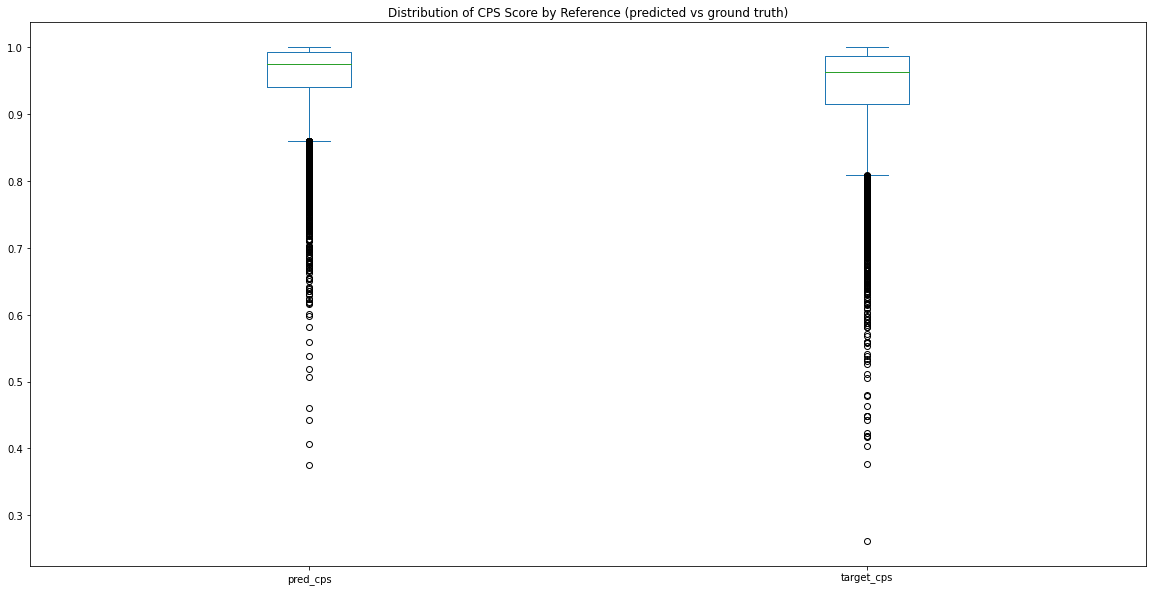

In [15]:
ste.metric_df[["pred_cps", "target_cps"]].plot.box(
    title="Distribution of CPS Score by Reference (predicted vs ground truth)",
    figsize=(20, 10),
)

**Observation**
- Median `pred_cps` > `target_cps`--> this basically means that our model produces more modest changes when transfering style than the annotators do...

In [5]:
ste.metric_df.head()

rev_id                                        source_text  \
0  407536752  djibouti, as well as the puntland and somalila...   
1  761493048  he is now a varsity basketball head coach for ...   
2  466100890  most notably, on september 11, 2011, the bushe...   
3  551290772  interestingly, wilfred rhodes, who had destroy...   
4  656809415  the positive contribution of post-keynesian ec...   

                                         target_text  \
0  djibouti, as well as the puntland and somalila...   
1  he is now a varsity basketball head coach for ...   
2  the bushes joined the obamas in new york city ...   
3  wilfred rhodes, who had destroyed the derbyshi...   
4  the contribution of post-keynesian economics h...   

                                           pred_text  pred_sti  target_sti  \
0  djibouti, as well as the puntland and somalila...    0.0016      0.0349   
1  he is now a varsity basketball head coach for ...    0.9437      0.9437   
2  in 2011, the bushes joined the obamas in new y...    0.1087      0.2052   
3  wilfred rhodes, who had destroyed the derbyshi...    0.0968      0.0968   
4  the effect of post-keynesian economics has ext...    0.1538      0.1748   

                                  masked_source_text  \
0  djibouti, as well as the puntland and somalila...   
1  he is now a varsity basketball head coach for ...   
2  most notably, on september 11, 2011, the bushe...   
3  [PAD]ly, wilfred rhodes, who had destroyed the...   
4  the positive [PAD] of post - keynesian economi...   

                                    masked_pred_text  pred_cps  \
0  djibouti, as well as the puntland and somalila...  0.997392   
1  he is now a [PAD] basketball head coach for th...  0.960442   
2  in 2011, the bushes joined the obamas in new y...  0.938260   
3  wilfred rhodes, who had destroyed the derbyshi...  0.963722   
4  the effect of post - keynesian economics has e...  0.959976   

                                  masked_target_text  target_cps  
0  djibouti, as well as the puntland and somalila...    0.977357  
1  he is now a [PAD] basketball head coach for th...    0.960442  
2  the bushes joined the obamas in new york city ...    0.928025  
3  wilfred rhodes, who had destroyed the derbyshi...    0.963722  
4  the contribution of post - keynesian economics...    0.966437

In [7]:
ste.metric_df[["masked_source_text", "masked_pred_text", "pred_cps"]].sort_values(
    by="pred_cps", ascending=False
)

masked_source_text  \
6985  because the city is not adjacent to the new ha...   
2591  by the grace of [PAD], king of serbia, bosnia,...   
3801  however, [PAD] creator, laurence lundblade, in...   
6036  they are sometimes inferred from other legal r...   
6019  today, anneliese's grave in klingenberg am mai...   
...                                                 ...   
5859             [PAD], closure, and enduring reminders   
2850  archie is a good fellow, but also an accident ...   
2389                   give it up for [PAD] relief rant   
6509            incompetent to stand trial, legal [PAD]   
5587  [PAD] - hawaiian responses to the sovereignty ...   

                                       masked_pred_text  pred_cps  
6985  because the city is not adjacent to the new ha...  1.000000  
2591  by the grace of [PAD], king of serbia, bosnia,...  1.000000  
3801  however, [PAD] creator, laurence lundblade, in...  1.000000  
6036  they are sometimes inferred from other legal r...  1.000000  
6019  today, anneliese's grave in klingenberg am mai...  1.000000  
...                                                 ...       ...  
5859                        decline, closure and [PAD]s  0.507415  
2850  [PAD] is a good fellow, but also an accident w...  0.460318  
2389                       [PAD] it up for comic relief  0.443059  
6509                                        legal [PAD]  0.406815  
5587                   opposition to the [PAD] movement  0.375690  

[8607 rows x 3 columns]